In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

Logistic Regression을 이용한 SingleLayer 구현

In [77]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0) -> None:
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate
        # storing validation losses
        self.val_losses = []
        self.l1 = l1
        self.l2 = l2
    
    def forpass(self, X):
        z = np.dot(X, self.w) + self.b
        return z
    
    def backprop(self, X, err):
        m = len(X)
        w_grad = np.dot(X.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, X, y, epochs=100, X_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(X)
        self.w = np.ones((X.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy())
        for i in range(epochs):
            z = self.forpass(X)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop(X, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(X_val, y_val)
            
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, X_val, y_val):
        z = self.forpass(X_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
    
    def predict(self, X):
        z = self.forpass(X)
        return z > 0

    def score(self, X, y):
        return np.mean(self.predict(X) == y.reshape(-1, 1))

In [70]:
a = np.array([[1,2,3],
              [4,5,6]])
print(a.T)

[[1 4]
 [2 5]
 [3 6]]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, test_size=0.2, random_state=42)

In [11]:
layer = SingleLayer()
layer.fit(X_train, y_train)
layer.score(X_test, y_test)

C:\Users\minja\AppData\Local\Temp\ipykernel_13036\2668374823.py:21: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))


0.9298245614035088

tuning

In [14]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3, random_state=42)

In [15]:
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

0.8333333333333334

In [16]:
sgd = SGDClassifier(loss='hinge', max_iter=100, tol=1e-3, random_state=42)

In [17]:
sgd.fit(X_train, y_train)
sgd.score(X_test, y_test)

0.9385964912280702

In [18]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(X_train), len(X_val))

364 91


In [19]:
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(X_train, y_train)
sgd.score(X_val, y_val)

0.6923076923076923

['mean perimeter' 'mean area']


Text(0, 0.5, 'value')

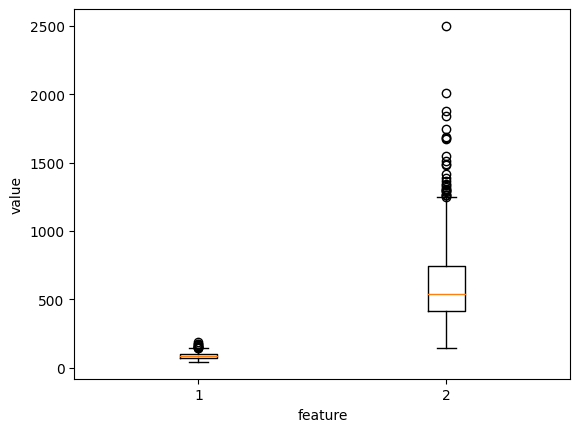

In [20]:
print(cancer.feature_names[[2, 3]])
plt.boxplot(X_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')

Scale에 따른 preprocessing 필요.

In [24]:
layer1 = SingleLayer()
layer1.fit(X_train, y_train)
layer1.score(X_val, y_val)

C:\Users\minja\AppData\Local\Temp\ipykernel_13036\377369508.py:23: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-z))


0.9120879120879121

Text(0.5, 0, 'w[3]')

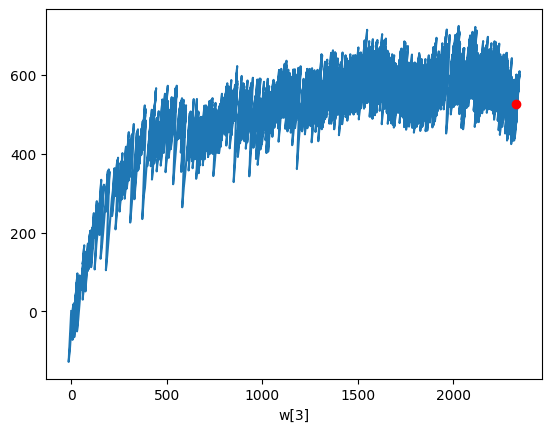

In [25]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.xlabel('w[3]')

In [26]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)
X_train_scaled = (X_train - train_mean) / train_std

Text(0, 0.5, 'w[3]')

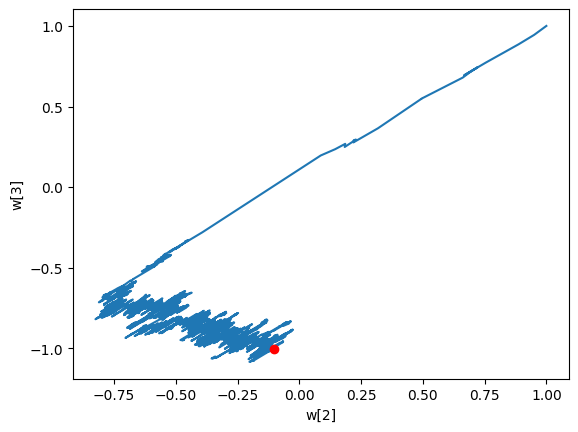

In [28]:
layer2 = SingleLayer()
layer2.fit(X_train_scaled, y_train)
layer2.score(X_val, y_val)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')

scale을 수정하면 validation set의 scale도 조정해줘야 한다. 이 때, scatter plot을 통해 비교해보면, val set와 training set의 scale을 같은 비율로 조정하지 않으면 문제가 발생할 수 있다.

In [38]:
X_val_scaled = (X_val - train_mean) / train_std
layer2.score(X_val_scaled, y_val)

0.967032967032967

In [35]:
layer3 = SingleLayer()
layer3.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)

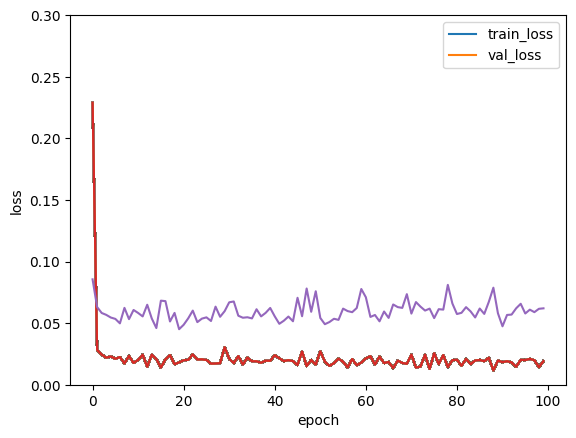

In [36]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])

In [40]:
layer4 = SingleLayer()
layer4.fit(X_train_scaled, y_train, epochs=20)
layer4.score(X_val_scaled, y_val)

0.978021978021978

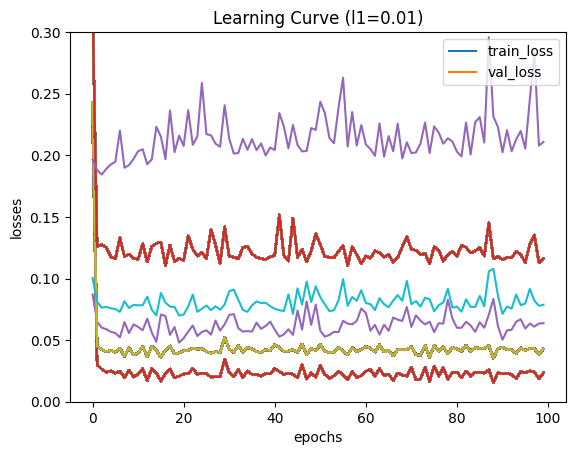

In [44]:
l1_list = [0.0001, 0.001, 0.01]
    
for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.xlabel('weight')
    plt.xlabel('value')
    plt.ylim(-4, 4)

In [45]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(X_train_scaled, y_train, epochs=20)
layer5.score(X_val_scaled, y_val)

0.978021978021978

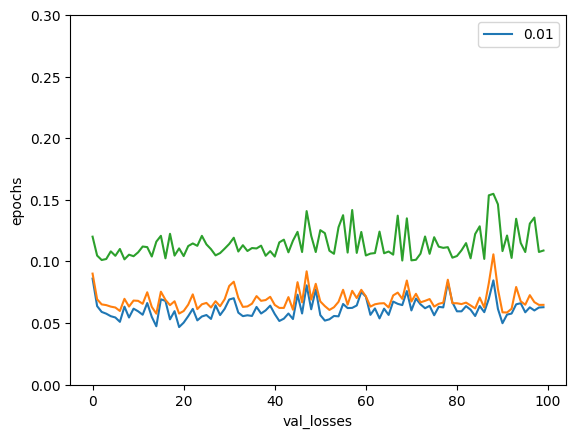

In [49]:
l2_list = [0.0001, 0.001, 0.01]
for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val)
    
    plt.plot(lyr.val_losses)
    plt.xlabel('val_losses')
    plt.ylabel('epochs')
    plt.ylim(0, 0.3)
    plt.legend([l2])

In [50]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(X_train_scaled, y_train, epochs=20)
layer6.score(X_val_scaled, y_val)

0.967032967032967

In [51]:
np.sum(layer6.predict(X_val_scaled) == y_val)

88

In [52]:
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.01, random_state=42)
sgd.fit(X_train_scaled, y_train)
sgd.score(X_val_scaled, y_val)

0.978021978021978

In [54]:
validation_scores = []

k = 10
bins = len(X_train) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = X_train_all[start:end]
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start)) + list(range(end, len(X_train)))
    train_fold = X_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
    
print(np.mean(validation_scores))

0.9583333333333333


In [56]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, X_train_all, y_train_all, cv=10)
print("Not preprocessed: ", np.mean(scores['test_score']))

Not preprocessed:  0.850096618357488


In [57]:
X_train_all_scaled = (X_train_all - np.mean(X_train_all, axis=0)) / np.std(X_train_all, axis=0)
scores = cross_validate(sgd, X_train_all_scaled, y_train_all, cv=10)
print("Preprocessed: ", np.mean(scores['test_score']))

Preprocessed:  0.9693719806763286


In [60]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, X_train_all, y_train_all, cv=10, return_train_score=True)
print('Score in training set :',np.mean(scores['train_score']))
print('Score in test set :',np.mean(scores['test_score']))

Score in training set : 0.9875478561631581
Score in test set : 0.9694202898550724


In [72]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train,  y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [73]:
print(X_train.shape, X_val.shape)

(364, 30) (91, 30)


In [78]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [79]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(X_val_scaled, y_val)

0.978021978021978

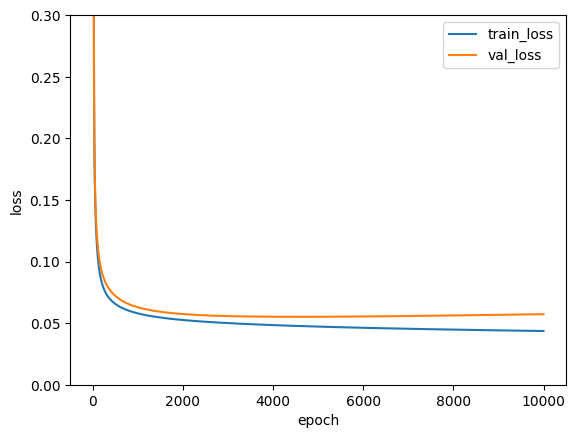

In [80]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])

Text(0, 0.5, 'w3')

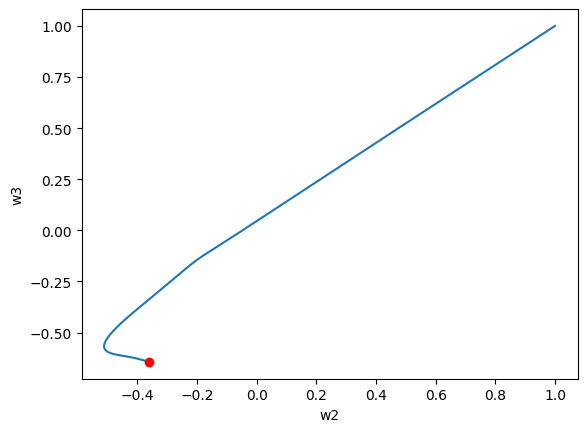

In [81]:
w2 = []
w3 = []

for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w2')
plt.ylabel('w3')